In this notebook, we prepare step by step the entraining plume. In short, we go through the following steps to compute the plume.

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# Constants
cp = 1005.0
Rv = 461.5
Rd = 287.04
g = 9.81

# Set up the atmospheric profiles

In [42]:
# Assume we have a profile of theta and q on height coordinates, and the surface pressure
L = 10_000
n = 256
p0 = 101300.0

dz = L / n
z = np.arange(dz/2, L, dz)
zh = np.arange(0, L+dz/2, dz)
theta = 288.1 + 0.006 * z
thetah = 288.1 + 0.006 * zh
Hq = 2500
qt = 0.005 * np.exp(-z/Hq)
qth = 0.005 * np.exp(-zh/Hq)

First, we assume that the environment is dry, and we compute the ambient pressure. We use the gas law for moist air.
$$
p = \rho R_\mathrm{d} \pi \theta_\mathrm{v}
$$
with $\pi = \left( \dfrac{p}{p_0} \right)^\frac{R_d}{c_p}$.

Then, we use hydrostatic balance and substitute the gas law:

$$
\begin{align}
\dfrac{\partial p}{\partial z}
&= -\rho g \\
&= -\dfrac{p g}{R_\mathrm{d} \pi \theta_\mathrm{v}} \\
\dfrac{\partial p^\frac{R_\mathrm{d}}{c_\mathrm{p}}}{\partial z}
&= -\dfrac{g}{c_\mathrm{p}}\dfrac{p_0^\frac{R_\mathrm{d}}{c_\mathrm{p}} }{\theta_\mathrm{v}} 
\end{align}
$$
with the latter equation, we can solve the pressure.

In [43]:
# We assume the base state is dry, so no saturation adjustment.
thetav = theta * (1 + (Rv/Rd - 1)*qt)
thetavh = thetah * (1 + (Rv/Rd - 1)*qth)

# Compute the pressure profile.
ph_Rdcp = np.zeros_like(zh)
ph_Rdcp[0] = p0**(Rd/cp)
for i in range(1, len(ph_Rdcp)):
    ph_Rdcp[i] = ph_Rdcp[i-1] - g/cp * p0**(Rd/cp) / thetav[i-1] * dz

ph = ph_Rdcp**(cp/Rd)
p = np.exp(0.5*(np.log(ph[:-1]) + np.log(ph[1:])))

exner = (p/p0)**(Rd/cp)
exnerh = (ph/p0)**(Rd/cp)

T = exner*theta
Th = exnerh*thetah

rho = p / (Rd * exner * thetav)
rhoh = ph / (Rd * exnerh * thetavh)

print(zh[-1], ph[-1], exnerh[-1], Th[-1])

10000.0 27977.338817837815 0.6924671547054013 241.04781655295022


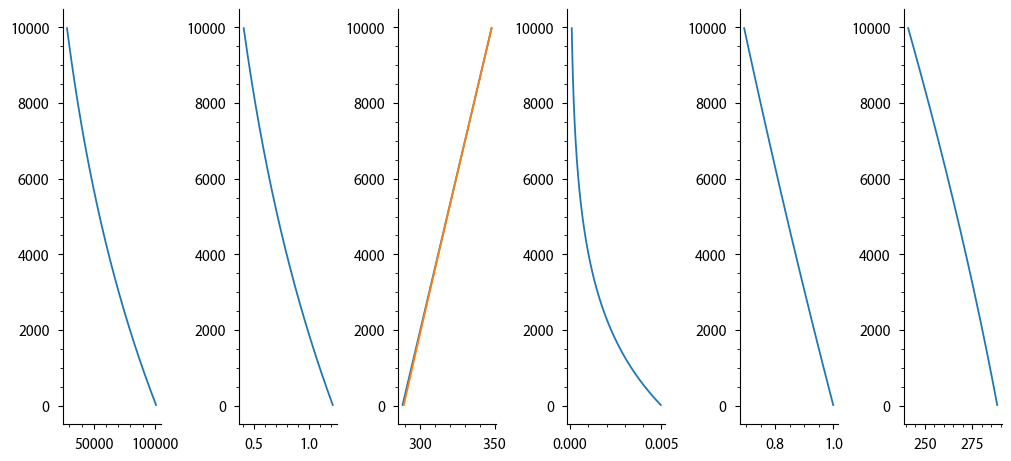

In [89]:
plt.figure(figsize=(10, 4.5), constrained_layout=True)
plt.subplot(161)
plt.plot(p, z)
plt.subplot(162)
plt.plot(rho, z)
plt.subplot(163)
plt.plot(theta, z)
plt.plot(thetav, z)
plt.subplot(164)
plt.plot(qt, z)
plt.subplot(165)
plt.plot(exner, z)
plt.subplot(166)
plt.plot(T, z)

# Calculate the plume ascent

In [80]:
# Define excess temperature and humidity and fire size (this can go into input).
dtheta = 1
dqv = 0.001
dthetav_bot = (theta[0] + dtheta) * (1 + (Rv/Rd - 1)*(qt[0] + dqv)) - thetav[0]
area_bot = 100*100
w_bot = 0.01

In [81]:
# First, set the near-surface plume conditions
theta_plume = theta.copy()
qt_plume = qt.copy()

b_plume = np.zeros_like(theta)
area_plume = np.zeros_like(theta)
m_plume = np.zeros_like(theta)
w_plume = np.zeros_like(theta)
e_plume = np.zeros_like(theta)
d_plume = np.zeros_like(theta)

b_plume[0] = g/thetav[0] * dthetav_bot
area_plume[0] = area_bot
w_plume[0] = w_bot
e_plume[0] = rho[0] / (2*w_plume[0]) * b_plume[0]

In [84]:
# Loop through the profile
for i in range(1, len(z)):
    # Mass flux through plume
    m_plume[i] = m_plume[i-1] + (e_plume[i-1] - d_plume[i-1]) * dz
    
    # Apply the mass flux to the conserved variables
    theta_plume[i] = theta_plume[i-1] + e_plume[i-1] * (theta_plume[i-1] - theta[i-1]) / m_plume[i-1] * dz
    qt_plume[i] = qt_plume[i-1] + e_plume[i-1] * (qt_plume[i-1] - qt[i-1]) / m_plume[i-1] * dz

    b_plume[i] = g/thetav[i] * (theta_plume[i] * (1 + (Rv/Rd - 1)*qt_plume[i]) - thetav[i])

    # Solve the vertical velocity
    a_w = 1
    b_w = 0
    w_plume[i] = -b_w * e_plume[i-1] * w_plume[i-1] + a_w * area_plume[i-1] * rho[i-1] * b_plume[i-1] / m_plume[i-1] * dz

    z_sl = 100.0
    
    if z[i] < z_sl:
        # Entrainment and detrainment in the surface layer.
        lambda_mix = 30
        
        e_plume[i] = area_plume[i-1] * rho[i-1] / (2 * w_plume[i-1]) * b_plume[i-1]
        d_plume[i] = area_plume[i-1] * rho[i-1] * np.sqrt(lambda_mix) / np.sqrt(area_plume[0]) * (
            np.sqrt(z[i]) * (w_plume[i] - w_plume[i-1]) / dz + w_plume[i-1] / (2 * np.sqrt(z[i])))

    else:
        # Entrainment and detrainment above the surface layer.
        beta = 1 # Fractional detrainment above surface layer.
        epsi = e_plume[i] / m_plume[i]
        delt = epsi / beta
    
        e_plume[i] = epsi * m_plume[i]
        d_plume[i] = delt * m_plume[i]

    area_plume[i] = m_plume[i] / (rho[i] * w_plume[i])

/var/folders/4f/nykt4nhx4kn12sz633_msth40000gn/T/ipykernel_6416/2678747868.py:7: RuntimeWarning: invalid value encountered in scalar divide
  theta_plume[i] = theta_plume[i-1] + e_plume[i-1] * (theta_plume[i-1] - theta[i-1]) / m_plume[i-1] * dz
/var/folders/4f/nykt4nhx4kn12sz633_msth40000gn/T/ipykernel_6416/2678747868.py:8: RuntimeWarning: invalid value encountered in scalar divide
  qt_plume[i] = qt_plume[i-1] + e_plume[i-1] * (qt_plume[i-1] - qt[i-1]) / m_plume[i-1] * dz
/var/folders/4f/nykt4nhx4kn12sz633_msth40000gn/T/ipykernel_6416/2678747868.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  w_plume[i] = -b_w * e_plume[i-1] * w_plume[i-1] + a_w * area_plume[i-1] * rho[i-1] * b_plume[i-1] / m_plume[i-1] * dz
/var/folders/4f/nykt4nhx4kn12sz633_msth40000gn/T/ipykernel_6416/2678747868.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  w_plume[i] = -b_w * e_plume[i-1] * w_plume[i-1] + a_w * area_plume[i-1] * rho[i-1] * b_plume[i-1] / m_plume[i-1] * 

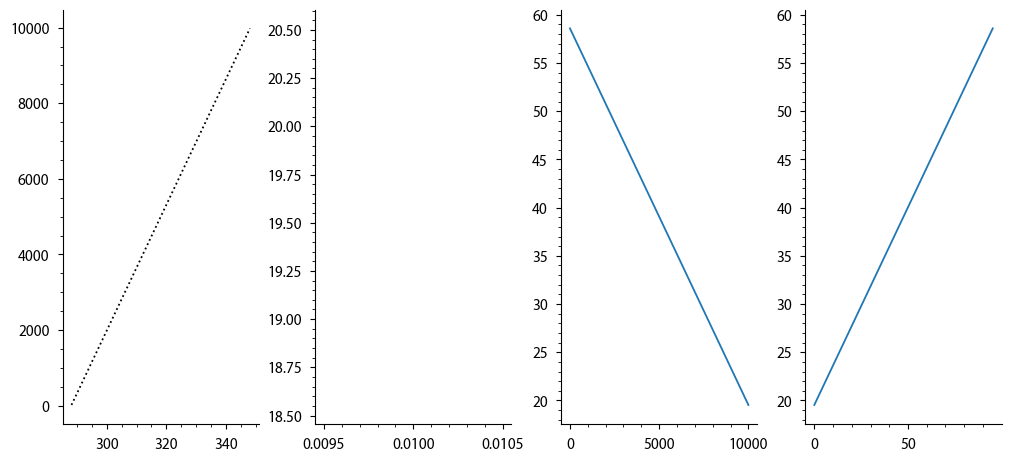

In [88]:
plt.figure(figsize=(10, 4.5), constrained_layout=True)
plt.subplot(141)
plt.plot(theta_plume, z)
plt.plot(theta, z, 'k:')
plt.subplot(142)
plt.plot(w_plume, z)
plt.subplot(143)
plt.plot(area_plume, z)
plt.subplot(144)
plt.plot(m_plume, z)